In [1]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


## Wave equation 1D

Consider the initial value problem (IVP) described by the partial differential equation for the wave equation:

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0, \quad t > t_0, \quad x \in [a, b],
$$

This problem has analytical solutions of the form \( u(x, t) = f(x - ct) + f(x + ct) \). For example, we can choose

$$
f(y) = \frac{1}{2} \exp\left(\frac{y}{2\sigma}\right)^2
$$

to define an initial condition and evaluate it at \( u(x, t_0) \). Since it is a second-order partial differential equation, we also provide an initial condition for the velocity in the form of

$$
\left. \frac{\partial u(x, t)}{\partial t} \right|_{t=t_0}.
$$


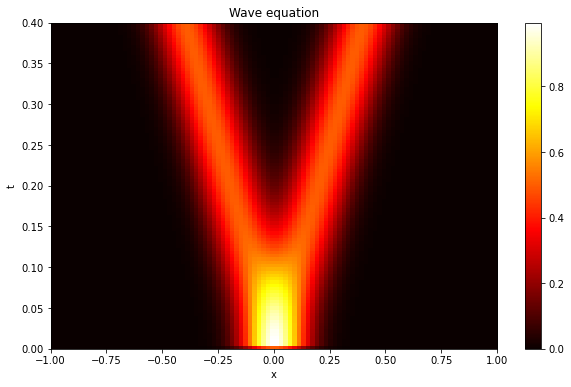

In [2]:
# Initial condition
def f(y,sigma):
    #return (1/2)*np.exp(y/(2*sigma))**2
    return (1/2)*np.exp(-y**2/(2*sigma**2))

# Find the solution
N = 100
x = np.linspace(-1,1,N)
t = np.linspace(0,0.4,N)

sigma = 0.1
c = 1

u = np.zeros((N,N))

u[:, 0] = f(x, sigma)

for j in range(1, N):
    for i in range(N):
        u[i, j] = f(x[i] - c*t[j], sigma) + f(x[i] + c*t[j], sigma)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
img = ax.imshow(u.T, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto', origin='upper', cmap='hot')
plt.gca().invert_yaxis()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wave equation')
plt.colorbar(img)
plt.show()


## Burger's equation
Consider the PDE problem
$$u_t + \frac{1}{2} (u^2)_x = \epsilon u_{xx}, \quad -1 < x < 1, \quad t > 0,$$
$$u(x,0) = \eta(x), \quad -1 \leq x \leq 1.$$
Assume that the diffusion coefficient is a constant, $\epsilon > 0$.
Setup the problem with an initial condition, $\eta(x) = - \sin(\pi x)$. Establish convergence as a part of solving the problem using a Fourier method for $\epsilon = 0.01/\pi$ with the objective to estimate the value $u_x|_{x=0} = −152.00516$ at time $t = 1.6037 \pi$.
How accurate can you estimate this gradient?
How fast does the solver converge? Plot the evolving solution from the initial time to the final time $t$.

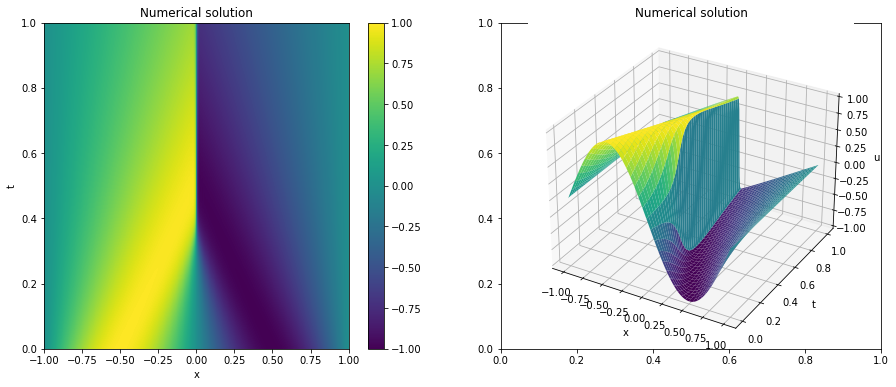

In [3]:
N = 256+1
x = np.linspace(-1,1, N)
tend = 1.6037/np.pi
tend = 1
t = np.linspace(0, tend, N)

dx = x[1] - x[0]

# Initial condition
u0 = -np.sin(np.pi*x)

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

# Solve the ODE using fft
def rhsBurgers(u, t, kappa, epsilon):
    uhat = fft(u)
    duhat = (1j)*kappa*uhat
    dduhat = -np.power(kappa,2)*uhat
    du = ifft(duhat)
    ddu = ifft(dduhat)
    dudt = -u*du + epsilon*ddu
    return dudt.real

u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

# Plot the solution
fig, ax = plt.subplots(1,2,figsize=(15, 6))
img = ax[0].imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto', origin='upper')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()  # Invert the y-axis

# Plot in 3d
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, u, cmap='viridis')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('u')
ax[1].set_title('Numerical solution')
plt.show()


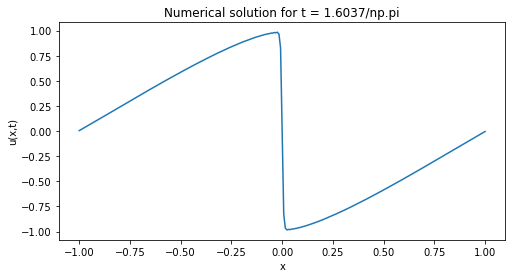

In [4]:
tend = 1.6037/np.pi
t = np.linspace(0, tend, N)
u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

# Plot for t = 1.6037/np.pi
u_snapshot = u[-1,:]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, u_snapshot)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Numerical solution for t = 1.6037/np.pi')
plt.show()


## Solve the Burgers' equation using NN

In [5]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * u.shape[0])

u_train = u[:n_train, :]
u_test = u[n_train:, :]

# Split X and T into training and testing sets
X_train = X[:n_train, :]
X_test = X[n_train:, :]
T_train = T[:n_train, :]
T_test = T[n_train:, :]

# Plot u_train in 3D
if False:
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X_train,T_train,u_train, cmap='viridis')
    ax1.set_title('u train')
    ax1.set_xlabel('X')
    ax1.set_ylabel('T')
    ax1.set_zlabel('Value')

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X_test,T_test,u_test, cmap='viridis')
    ax2.set_title('u test')
    ax2.set_xlabel('X')
    ax2.set_ylabel('T')
    ax2.set_zlabel('Value')

    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X,T,u, cmap='viridis')
    ax3.set_title('u')
    ax3.set_xlabel('X')
    ax3.set_ylabel('T')
    ax3.set_zlabel('Value')

    plt.show()

### (i) FNN

Epoch 1/100
6/6 [==============================] - 1s 27ms/step - loss: 0.3207 - val_loss: 0.0763
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0316 - val_loss: 0.0622
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0234 - val_loss: 0.0501
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.0416
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0367
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.0227
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0167
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0125
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0130
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0094
Epoch 11/100
6/6 [==========

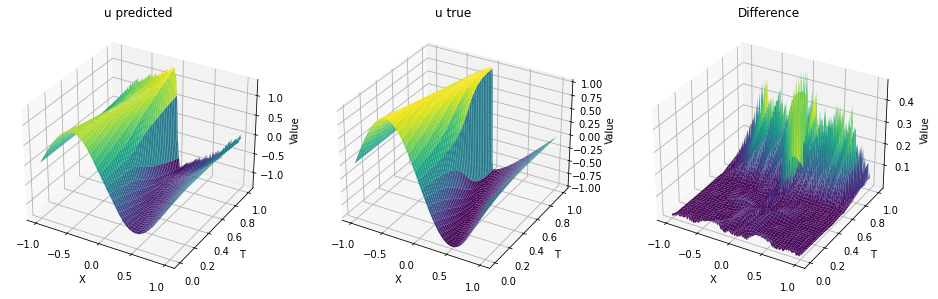

In [274]:
# Define the FNN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(u.shape[1]))  # Output layer with the same shape as u
learning_rate = 0.01  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')
#model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack((X_train, T_train)), u_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing data
loss = model.evaluate(np.hstack((X_test, T_test)), u_test)
print("Test Loss:", loss)

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot u predicted in 3D
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X,T,predictions, cmap='viridis')
ax1.set_title('u predicted')
ax1.set_xlabel('X')
ax1.set_ylabel('T')
ax1.set_zlabel('Value')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X,T,u, cmap='viridis')
ax2.set_title('u true')
ax2.set_xlabel('X')
ax2.set_ylabel('T')
ax2.set_zlabel('Value')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X,T,np.abs(predictions-u), cmap='viridis')
ax3.set_title('Difference')
ax3.set_xlabel('X')
ax3.set_ylabel('T')
ax3.set_zlabel('Value')

plt.show()

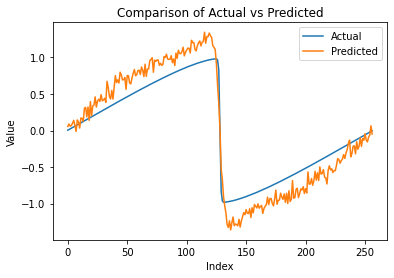

In [275]:
# Choose a specific index to plot (for example, the last row)
index = -1

plt.plot(u[index], label='Actual')
plt.plot(predictions[index], label='Predicted')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Actual vs Predicted')
plt.show()

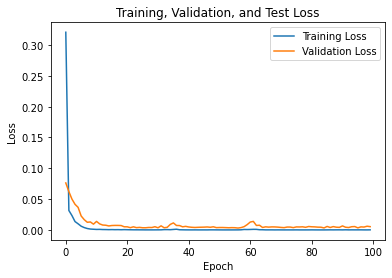

In [281]:
# Evaluate the model on the test data and store the test loss
#test_loss = model.evaluate(X_test, u_test)

# Plot the training, validation, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

### (ii) LSTM

In [10]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1] + T.shape[1], 1), return_sequences=False))
model.add(Dense(u.shape[1]))  # Output layer with the same shape as u
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack((X_train, T_train)), u_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing data
loss = model.evaluate(np.hstack((X_test, T_test)), u_test)
print("Test Loss:", loss)

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot u predicted in 3D
fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X,T,predictions, cmap='viridis')
ax1.set_title('u predicted')
ax1.set_xlabel('X')
ax1.set_ylabel('T')
ax1.set_zlabel('Value')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X,T,u, cmap='viridis')
ax2.set_title('u true')
ax2.set_xlabel('X')
ax2.set_ylabel('T')
ax2.set_zlabel('Value')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X,T,np.abs(predictions-u), cmap='viridis')
ax3.set_title('Difference')
ax3.set_xlabel('X')
ax3.set_ylabel('T')
ax3.set_zlabel('Value')

plt.show()

Epoch 1/10
6/6 [==============================] - 9s 606ms/step - loss: 0.4834 - val_loss: 0.4284
Epoch 2/10
6/6 [==============================] - 2s 292ms/step - loss: 0.4462 - val_loss: 0.3083
Epoch 3/10
6/6 [==============================] - 2s 347ms/step - loss: 0.2914 - val_loss: 0.1514
Epoch 4/10
2/6 [=========>....................] - ETA: 1s - loss: 0.1420

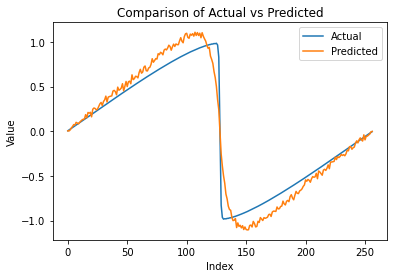

In [8]:
# Choose a specific index to plot (for example, the last row)
index = -1

plt.plot(u[index], label='Actual')
plt.plot(predictions[index], label='Predicted')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Actual vs Predicted')
plt.show()

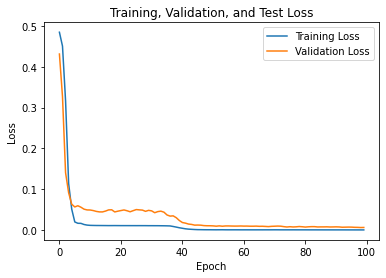

In [9]:
# Plot the training, validation, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()